In this research the Worldbank data on international development will be analyzed.
Due to the sheer number of indicators (features), the task of finding out patterns on the whole dataset is of extreme complexity. The indicators are from different fields (macroeconomics, social, ecology, etc.), many of them are a combination of other indicators (GDP, GDP per capita, % of GDP), or the same indicator in different units (local currency real, local currency nominal, PPP, US$); also, the data is itself combined from different sources and its availability (percentage of available values) can vary drastically by country, year and indicator. In addition, many of macroeconomic indicators have a tendency to auto-correlate or inter-correlate if compared by nominal values. Therefore, it was decided to manually choose a field of research and the resulting indicator (target label).

I: Target label (TL) - life expectancy:
- one of the core sociological indicators.
- subject to influence by many factors.
- measured as an estimation based on mortality ratio over one year, so less/no lag is expected when looking for correlations.

Main features: will be found in the process of researching data. After removing the least available features (based on share of N/A), we will manually choose the ones that might have explainatory power, after that test it by calculating correlation.

In [208]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import statsmodels.regression.linear_model as sm_lm
import statsmodels.stats.outliers_influence as sm_ol
import statsmodels.stats.diagnostic as sm_diag
from statsmodels.tools.tools import add_constant
import scipy
import math
import os, gc
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [209]:
dataset1 = os.listdir("../input")
dataset1 = list(filter(lambda x: x not in ['countries.csv', 'selected indicators.xlsx', 'definitions.csv', 'data2.xlsx'], dataset1))
df_list = [pd.read_csv("../input/"+f) for f in dataset1]
df = pd.concat(df_list, ignore_index=False, axis=1)
df_ctr=pd.read_csv("../input/countries.csv")
ctr=df_ctr['Country Name'].values.tolist()

print(dataset1)
print(df.shape)
print(len(ctr))

['2018-2009.csv', '2008-1999.csv', '1988-1979.csv', '1978-1969.csv', '1968-1960.csv', '1998-1989.csv']
(422141, 71)
217


II: clearing the data.
Currently the dataset contains ((264 countries x 1599 indicators + 5 technical fields) x (59 periods + 12 country/indicator columns)) = 422141 x 71 data units.

The goal is to leave as many countries, and as many years as possible. Indicators will have their number reduced the most.

Deleting duplicate headers columns and technical fields, sort by year.

Note that this was done in several iterations, by checking which country-indicators and/or year-indicators with least availability, correlation to the TL and both. Shown is only the final version.

In [210]:
df=df.drop(df.index[[-1,-2,-3,-4,-5]])
df = df.loc[:,~df.columns.duplicated()]
df = df.reindex(sorted(df.columns), axis=1)
df=df.iloc[::,::-1]
print(df.shape)

(422136, 61)


In [211]:
df.head(3)

Series Name Country Name  2018  2017  \
0  2005 PPP conversion factor, GDP (LCU per inter...  Afghanistan   nan   nan   
1  2005 PPP conversion factor, private consumptio...  Afghanistan   nan   nan   
2  Access to clean fuels and technologies for coo...  Afghanistan   nan   nan   

    2016   2015   2014   2013   2012   2011   2010   2009   2008   2007  \
0    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan   
1    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan   
2 32.440 30.100 27.990 26.170 24.080 22.330 20.680 18.840 17.440 15.990   

    2006   2005   2004   2003   2002  2001  2000  1999  1998  1997  1996  \
0    nan 15.132    nan    nan    nan   nan   nan   nan   nan   nan   nan   
1    nan 16.710    nan    nan    nan   nan   nan   nan   nan   nan   nan   
2 14.810 13.490 12.430 11.460 10.390 9.510 8.800   nan   nan   nan   nan   

   1995  1994  1993  1992  1991  ...   1989  1988  1987  1986  1985  1984  \
0   nan   nan   nan   nan   nan  ...    nan   nan   nan   nan   nan   nan   
1   nan   nan   nan   nan   nan  ...    nan   nan   nan   nan   nan   nan   
2   nan   nan   nan   nan   nan  ...    nan   nan   nan   nan   nan   nan   

   1983  1982  1981  1980  1979  1978  1977  1976  1975  1974  1973  1972  \
0   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   
1   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   
2   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   

   1971  1970  1969  1968  1967  1966  1965  1964  1963  1962  1961  1960  
0   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan  
1   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan  
2   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan  

[3 rows x 61 columns]

Groups of countries are linear combinations of data available in the rest of the dataset, so we delete them. First we check if all country names are read correctly and are present in the dataset.

In [212]:
tmp=df['Country Name'].values.tolist()
df_ctr=df_ctr[~df_ctr['Country Name'].isin(tmp)]
print(df_ctr.head())

Empty DataFrame
Columns: [Country Name]
Index: []


In [213]:
df=df[df['Country Name'].isin(ctr)]
print(df.shape)

(346983, 61)


In [214]:
df.isna().sum()/(df.isna().sum()+df.notna().sum())

Series Name    0.000
Country Name   0.000
2018           0.934
2017           0.600
2016           0.498
2015           0.464
2014           0.450
2013           0.458
2012           0.446
2011           0.448
2010           0.428
2009           0.464
2008           0.466
2007           0.463
2006           0.472
2005           0.469
2004           0.501
2003           0.515
2002           0.516
2001           0.529
2000           0.507
1999           0.564
1998           0.579
1997           0.584
1996           0.586
1995           0.586
1994           0.606
1993           0.611
1992           0.614
1991           0.625
1990           0.637
1989           0.695
1988           0.699
1987           0.699
1986           0.702
1985           0.704
1984           0.707
1983           0.709
1982           0.708
1981           0.710
1980           0.715
1979           0.727
1978           0.729
1977           0.728
1976           0.737
1975           0.742
1974           0.752
1973         

(output hidden)

Earlier and the most recent periods have far less data available, those are likely to be dropped.

Rearranging the data into multiindex pivot table.

In [215]:
df=df.melt(id_vars=['Country Name', 'Series Name'])
df.rename(columns={'variable': 'Year'}, inplace=True)
df = df.pivot_table(index='Series Name', columns=['Country Name', 'Year'], dropna = False)
df.head(2)

value                 \
Country Name                                       Afghanistan                  
Year                                                      1960 1961 1962 1963   
Series Name                                                                     
2005 PPP conversion factor, GDP (LCU per intern...         nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...         nan  nan  nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1964 1965 1966 1967 1968   
Series Name                                                                   
2005 PPP conversion factor, GDP (LCU per intern...  nan  nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...  nan  nan  nan  nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1969 1970 1971 1972 1973   
Series Name                                                                   
2005 PPP conversion factor, GDP (LCU per intern...  nan  nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...  nan  nan  nan  nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1974 1975 1976 1977 1978   
Series Name                                                                   
2005 PPP conversion factor, GDP (LCU per intern...  nan  nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...  nan  nan  nan  nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1979 1980 1981 1982 1983   
Series Name                                                                   
2005 PPP conversion factor, GDP (LCU per intern...  nan  nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...  nan  nan  nan  nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1984 1985 1986 1987 1988   
Series Name                                                                   
2005 PPP conversion factor, GDP (LCU per intern...  nan  nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...  nan  nan  nan  nan  nan   

                                                        ...                 \
Country Name                                            ...  Zimbabwe        
Year                                               1989 ...      1989 1990   
Series Name                                             ...                  
2005 PPP conversion factor, GDP (LCU per intern...  nan ...       nan  nan   
2005 PPP conversion factor, private consumption...  nan ...       nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1991 1992 1993 1994 1995   
Series Name                                                                   
2005 PPP conversion factor, GDP (LCU per intern...  nan  nan  nan  nan  nan   
2005 PPP conversion factor, private consumption...  nan  nan  nan  nan  nan   

                                                                             \
Country Name                                                                  
Year                                               1996 1997 1998 1999 2000   
Series Name   

In [216]:
df.shape

(1599, 12803)

(1599 indicators x (217 countries x 59 periods))

In [217]:
df.isna().sum(axis=1)/(df.isna().sum(axis=1)+df.notna().sum(axis=1))

Series Name
2005 PPP conversion factor, GDP (LCU per international $)                                                                                      0.986
2005 PPP conversion factor, private consumption (LCU per international $)                                                                      0.986
ARI treatment (% of children under 5 taken to a health provider)                                                                               0.966
Access to clean fuels and technologies for cooking (% of population)                                                                           0.749
Access to electricity (% of population)                                                                                                        0.554
Access to electricity, rural (% of rural population)                                                                                           0.601
Access to electricity, urban (% of urban population)                                          

output hidden

The core indicators: life expextancy, mortality rate and GDP are widely available - less than 30% of values are missing (although GDP PPP is not, so we will have to rely on GDP in US$, for international comparability. Not ideal, but should suffice). Most of the education and healthcare - related data are also sparcely available, so the model will have to do with more indirect estimation.

Since we have 60 observation per country-indicator, the threshhold to drop indicators is set to 50%, so we can hopefully leave about 30 observations on average.

In [218]:
df=df.dropna(axis=0, thresh=6402)
df.shape

(327, 12803)

Now that the data is more visually interpretable, we can use a table of % data missing for each year-indicator.

In [219]:
df.isna().sum(axis=1, level="Year")/(df.isna().sum(axis=1, level="Year")+df.notna().sum(axis=1, level="Year"))

Year                                                1960  1961  1962  1963  \
Series Name                                                                  
Adjusted net national income (current US$)         1.000 1.000 1.000 1.000   
Adjusted net national income per capita (curren... 1.000 1.000 1.000 1.000   
Adjusted savings: carbon dioxide damage (% of GNI) 1.000 1.000 1.000 1.000   
Adjusted savings: carbon dioxide damage (curren... 1.000 1.000 1.000 1.000   
Adjusted savings: consumption of fixed capital ... 1.000 1.000 1.000 1.000   
Adjusted savings: consumption of fixed capital ... 1.000 1.000 1.000 1.000   
Adjusted savings: education expenditure (% of GNI) 1.000 1.000 1.000 1.000   
Adjusted savings: education expenditure (curren... 1.000 1.000 1.000 1.000   
Adjusted savings: energy depletion (% of GNI)      1.000 1.000 1.000 1.000   
Adjusted savings: energy depletion (current US$)   1.000 1.000 1.000 1.000   
Adjusted savings: mineral depletion (% of GNI)     1.000 1.000 1.000 1.000   
Adjusted savings: mineral depletion (current US$)  1.000 1.000 1.000 1.000   
Adjusted savings: natural resources depletion (... 1.000 1.000 1.000 1.000   
Adjusted savings: net forest depletion (% of GNI)  1.000 1.000 1.000 1.000   
Adjusted savings: net forest depletion (current... 1.000 1.000 1.000 1.000   
Adolescent fertility rate (births per 1,000 wom... 0.106 0.106 0.106 0.106   
Age dependency ratio (% of working-age population) 0.115 0.115 0.115 0.115   
Age dependency ratio, old (% of working-age pop... 0.115 0.115 0.115 0.115   
Age dependency ratio, young (% of working-age p... 0.115 0.115 0.115 0.115   
Agricultural land (% of land area)                 1.000 0.184 0.184 0.184   
Agricultural land (sq. km)                         1.000 0.184 0.184 0.184   
Agricultural methane emissions (% of total)        1.000 1.000 1.000 1.000   
Agricultural methane emissions (thousand metric... 1.000 1.000 1.000 1.000   
Agricultural nitrous oxide emissions (% of total)  1.000 1.000 1.000 1.000   
Agricultural nitrous oxide emissions (thousand ... 1.000 1.000 1.000 1.000   
Agricultural raw materials exports (% of mercha... 1.000 1.000 0.664 0.654   
Agricultural raw materials imports (% of mercha... 1.000 1.000 0.668 0.654   
Agriculture, forestry, and fishing, value added... 0.797 0.793 0.788 0.779   
Agriculture, forestry, and fishing, value added... 1.000 0.876 0.866 0.862   
Agriculture, forestry, and fishing, value added... 0.876 0.871 0.866 0.866   
Agriculture, forestry, and fishing, value added... 0.876 0.866 0.862 0.862   
Agriculture, forestry, and fishing, value added... 0.797 0.793 0.788 0.779   
Agriculture, forestry, and fishing, value added... 0.806 0.806 0.806 0.797   
Air transport, freight (million ton-km)            1.000 1.000 1.000 1.000   
Air transport, passengers carried                  1.000 1.000 1.000 1.000   
Air transport, registered carrier departures wo... 1.000 1.000 1.000 1.000   
Aquaculture production (metric tons)               0.627 0.627 0.627 0.622   
Arable land (% of land area)                       1.000 0.198 0.198 0.198   
Arable land (hectares per person)                  1.000 0.203 0.203 0.203   
Arable land (hectares)                             1.000 0.198 0.198 0.198   
Birth rate, crude (per 1,000 people)               0.111 0.115 0.111 0.115   
Broad money (% of GDP)                             0.737 0.728 0.691 0.677   
Broad money (current LCU)                          0.700 0.687 0.645 0.631   
Broad money growth (annual %)                      1.000 0.700 0.687 0.645   
Broad money to total reserves ratio                0.820 0.811 0.793 0.779   
CO2 emissions (kg per 2010 US$ of GDP)             0.627 0.618 0.613 0.608   
CO2 emissions (kt)                                 0.304 0.300 0.290 0.286   
CO2 emissions (metric tons per capita)             0.304 0.300 0.290 0.286   
CO2 emissions from gaseous fuel consumption (% ... 0.304 0.300 0.290 0.286   
CO2 emissions from gas

output hidden

Removing years up to 1993 as well as 2017-18 due to low data availability, then we choose features based on their supposed relation to the TL and availability, as well as general indicators such as population, GDP, land area, to calculate relative values. Leaving 1 extra year (1994) to calculate inflation based on CPI, it will be removed afterwards.

In [220]:
ldrop = [str(i) for i in range(1960,1994)]
ldrop.append("2017")
ldrop.append("2018")
df=df.drop(columns=ldrop, level="Year")
ids = ['Adjusted savings: education expenditure (% of GNI)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
      'Age dependency ratio (% of working-age population)', 'Agricultural land (% of land area)', 'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Birth rate, crude (per 1,000 people)', 'Cereal production (metric tons)', 'Consumer price index (2010 = 100)', 'Death rate, crude (per 1,000 people)',
      'Fertility rate, total (births per woman)', 'GDP (constant 2010 US$)', 'Immunization, measles (% of children ages 12-23 months)', 'Land area (sq. km)', 'Land under cereal production (hectares)',
      'Life expectancy at birth, total (years)', 'Lower secondary school starting age (years)', 'Military expenditure (% of GDP)', 'Manufacturing, value added (% of GDP)', 
      'Mobile cellular subscriptions (per 100 people)', 'Population, total', 'Preprimary education, duration (years)', 'Primary education, duration (years)', 
      'Rural population (% of total population)', 'School enrollment, primary (% gross)', 'Services, value added (% of GDP)']
print(len(ids))
print(len(ids)-len(set(ids)))
df=df[df.index.isin(ids)]
df.shape

25
0


(25, 4991)

In [221]:
df_t=(df.isna().sum(axis=1, level="Country Name")/(df.isna().sum(axis=1, level="Country Name")+df.notna().sum(axis=1, level="Country Name"))).T

In [222]:
df_t

Series Name                     Adjusted savings: education expenditure (% of GNI)  \
Country Name                                                                         
Afghanistan                                                                 0.000    
Albania                                                                     0.000    
Algeria                                                                     0.000    
American Samoa                                                              0.000    
Andorra                                                                     0.000    
Angola                                                                      0.000    
Antigua and Barbuda                                                         0.000    
Argentina                                                                   0.000    
Armenia                                                                     0.000    
Aruba                                                                       0.000    
Australia                                                                   0.000    
Austria                                                                     0.000    
Azerbaijan                                                                  0.000    
Bahamas, The                                                                0.000    
Bahrain                                                                     0.000    
Bangladesh                                                                  0.000    
Barbados                                                                    0.000    
Belarus                                                                     0.000    
Belgium                                                                     0.000    
Belize                                                                      0.000    
Benin                                                                       0.000    
Bermuda                                                                     0.000    
Bhutan                                                                      0.000    
Bolivia                                                                     0.000    
Bosnia and Herzegovina                                                      1.000    
Botswana                                                                    0.000    
Brazil                                                                      0.000    
British Virgin Islands                                                      1.000    
Brunei Darussalam                                                           0.000    
Bulgaria                                                                    0.000    
Burkina Faso                                                                0.000    
Burundi                                                                     0.000    
Cabo Verde                                                                  0.000    
Cambodia                                                                    0.000    
Cameroon                                                                    0.000    
Canada                                                                      0.000    
Cayman Islands                                                              1.000    
Central African Republic                                                    0.000    
Chad                                                                        0.000    
Channel Islands                                                             1.000    
Chile                                                                       0.000    
China                                                                       0.000    
Colombia                                                                    0.000    
Comoros                                                                     0.000    
Congo, Dem. Rep.                            

output hidden

As we can see, countries that have a non-zero share of missing TL values generally have low number of observations on other indicators, so we are safe to drop any country which misses at least some TL observations.

Removing countries with high share of other missing indicators as well

In [223]:
ldrop=df_t.loc[df_t['Life expectancy at birth, total (years)']!=0].index.tolist()
ldrop+=df_t.loc[df_t['Immunization, measles (% of children ages 12-23 months)']!=0].index.tolist()
ldrop+=df_t.loc[df_t['GDP (constant 2010 US$)']>0.3].index.tolist()
ldrop+=df_t.loc[df_t['Consumer price index (2010 = 100)']>0.3].index.tolist()
ldrop+=df_t.loc[df_t['Agriculture, forestry, and fishing, value added (% of GDP)']>0.15].index.tolist()
del df_t
gc.collect()
print(set(ldrop))
df=df.drop(columns=ldrop, level="Country Name")
df.shape

{'Belarus', 'Libya', 'Korea, Dem. People’s Rep.', 'Puerto Rico', 'Eritrea', 'Solomon Islands', 'Sint Maarten (Dutch part)', 'West Bank and Gaza', 'Isle of Man', 'Lebanon', 'Turkmenistan', 'Aruba', 'St. Martin (French part)', 'American Samoa', 'Canada', 'Kiribati', 'Cuba', 'Timor-Leste', 'Channel Islands', 'Macao SAR, China', 'Syrian Arab Republic', 'Serbia', 'Turks and Caicos Islands', 'French Polynesia', 'Palau', 'Virgin Islands (U.S.)', 'Armenia', 'South Sudan', 'Dominica', 'Algeria', 'Bahrain', 'Montenegro', 'Belize', 'St. Lucia', 'Faroe Islands', 'Nauru', 'Namibia', 'Bermuda', 'Tuvalu', 'New Caledonia', 'United Arab Emirates', 'Curacao', 'Comoros', 'Somalia', 'Andorra', 'Kosovo', 'Gibraltar', 'Liechtenstein', 'Monaco', 'St. Kitts and Nevis', 'Cayman Islands', 'San Marino', 'Guinea', 'Venezuela, RB', 'Guam', 'Greenland', 'Marshall Islands', 'Liberia', 'Djibouti', 'Uzbekistan', 'Hong Kong SAR, China', 'British Virgin Islands', 'Zimbabwe', 'Afghanistan', 'Equatorial Guinea', 'Qatar', 

(25, 3312)

III: Hypotheses:
- Check the distribution of features. Normal distribution is expected, otherwise the data will need to be transformed if we want to use maximum likelyhood estimation or anything else that requires ~N dist of variables.
- Test the set of features for autocorrelation. Expected to have one, especially in GDP - related series.
- Test the data for heteroskedasticity. Same, expected to be present in series with a growth trend.
- Test the other variables for cross-correlation.
- TL by definition is based on mortality rate, so high correlation between the two is expected. Otherwise may suggest inconsistency in data/methodology or other errors.
- Other selected features except for auxiliary ones such as GDP, land area, cereal production are expected to have correlation with TL.

TL density function:

In [224]:
df=df.T

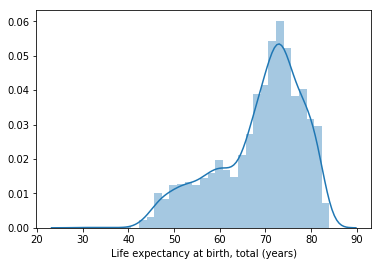

In [225]:
sns.distplot(df['Life expectancy at birth, total (years)']);

Correlation matrix:

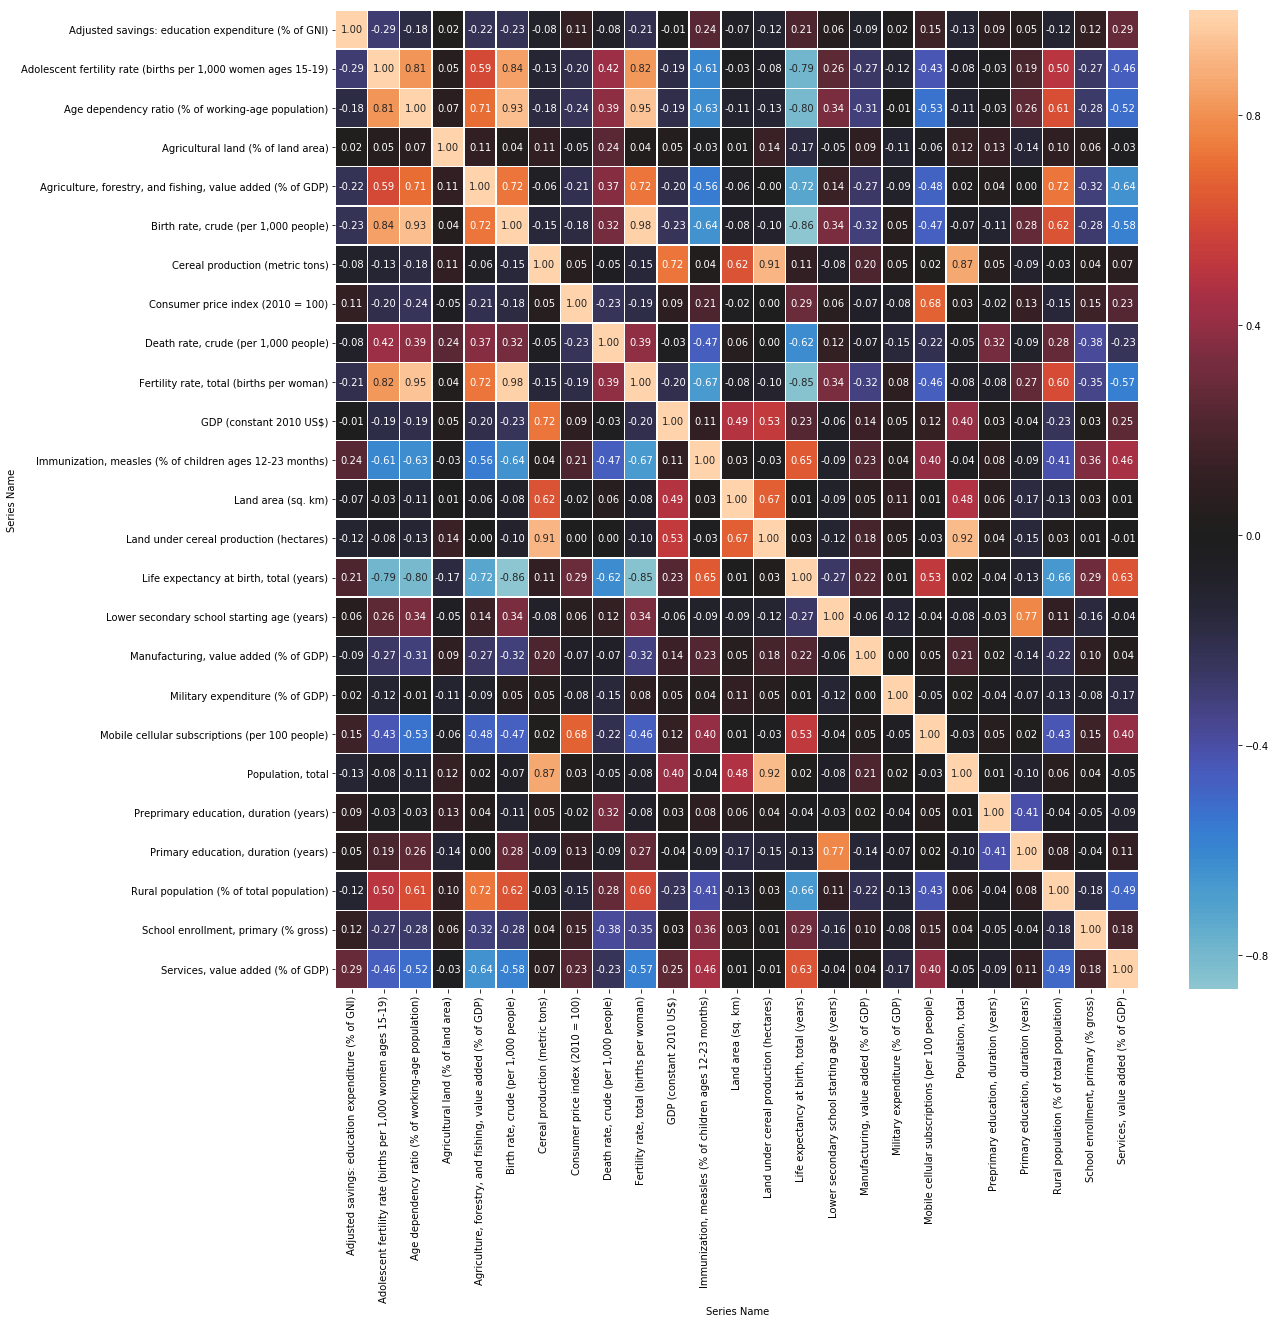

In [226]:
f,ax = plt.pyplot.subplots(figsize=(18, 18))
sns.heatmap(df.corr(method='pearson'), annot=True, linewidths=.5, fmt= '.2f',ax=ax, center = 0)
plt.pyplot.show()

Seems that the general idea is right - the TL has high correlation with the indicators we usually consider to be markers of high development of a country: low rural population and share of agri industry, high share of services in GDP, low fertility, high share of mobile phone users, and immunization. Also, the indicators that should not explain life expectancy, such as total GDP, land area and total population have near-zero correlation. 

- Death rate seems to correlate with life expectancy as it should by definition. Since we have checked this hypothesis, we can remove the indicator.

- Removing % of agri land, since it doesnt show significant correlation with TL.

- Removing birth rate and fertility rate - leaving adolescent fertility rate. The latter has close correlation to both, also high value of this metric is a sing of poor quality of life in a given country.

- Removing military expenditures (%GDP) and share of manufacturing in GDP, since they show low correlation, and have low availability.

- Removing % services value added - availability and its high negative correlation with agricultural value added, which is also correlated with TL and can be used as a substitute.

- Removing school enrollment - low correlation, low availability.

In [227]:
df=df.T
ids = ['Agricultural land (% of land area)', 'Birth rate, crude (per 1,000 people)', 'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)', 'Military expenditure (% of GDP)', 'Manufacturing, value added (% of GDP)',
       'School enrollment, primary (% gross)', 'Services, value added (% of GDP)']
df=df[~df.index.isin(ids)]
df=df.T
df.shape

(3312, 17)

Next we modify some indicators to have more meaning:

LN [GDP / population] (level of income)

LN GPD (linearized GDP)

Cereal prod / cereal land (agricultural productivity)

Cereal prod / population (food supply)

Primary + preprimary education duration (length of education)

Chain CPI difference (Inflation)

In [228]:
df["Agricultural productivity (tons/hectares) ln"]=(df["Cereal production (metric tons)"]/df["Land under cereal production (hectares)"]).apply(math.log)
df['GDP US$ per capita ln']=(df['GDP (constant 2010 US$)']/df["Population, total"]).apply(math.log)
df['GDP US$ ln']=df['GDP (constant 2010 US$)'].apply(math.log)
df["Basic education"]=df["Primary education, duration (years)"]+df["Preprimary education, duration (years)"]
df["Inflation"]=df["Consumer price index (2010 = 100)"]/df["Consumer price index (2010 = 100)"].shift(1)
df=df.T
df=df.drop(columns="1994", level="Year")
df=df.T
df.shape

(3168, 22)

Normality tests 1: distribution

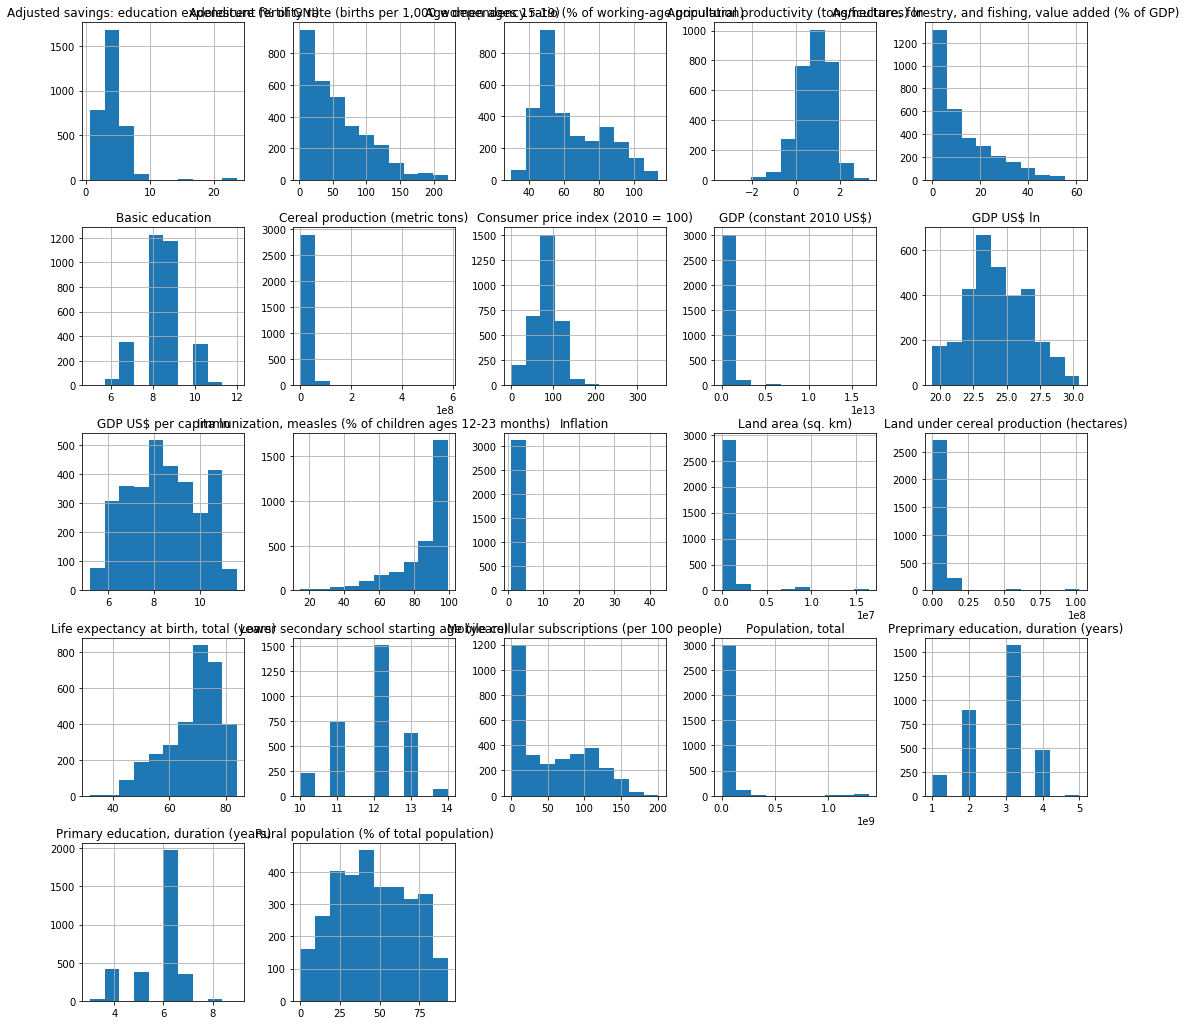

In [229]:
f,ax = plt.pyplot.subplots(figsize=(18, 18))
df[list(df.columns.values)].hist(figsize=(25, 20), ax=ax)
plt.pyplot.show()

Normality tests 2: Agostino, Pearson test

In [230]:
for x in list(df.columns.values):
    st,p = scipy.stats.normaltest(df[x],nan_policy='omit')
    print(x + " p-value = " + str('%.3f' % p))

Adjusted savings: education expenditure (% of GNI) p-value = 0.000
Adolescent fertility rate (births per 1,000 women ages 15-19) p-value = 0.000
Age dependency ratio (% of working-age population) p-value = 0.000
Agriculture, forestry, and fishing, value added (% of GDP) p-value = 0.000
Cereal production (metric tons) p-value = 0.000
Consumer price index (2010 = 100) p-value = 0.000
GDP (constant 2010 US$) p-value = 0.000
Immunization, measles (% of children ages 12-23 months) p-value = 0.000
Land area (sq. km) p-value = 0.000
Land under cereal production (hectares) p-value = 0.000
Life expectancy at birth, total (years) p-value = 0.000
Lower secondary school starting age (years) p-value = 0.000
Mobile cellular subscriptions (per 100 people) p-value = 0.000
Population, total p-value = 0.000
Preprimary education, duration (years) p-value = 0.000
Primary education, duration (years) p-value = 0.000
Rural population (% of total population) p-value = 0.000
Agricultural productivity (tons/hec

Normality tests 3: quantile-quantile

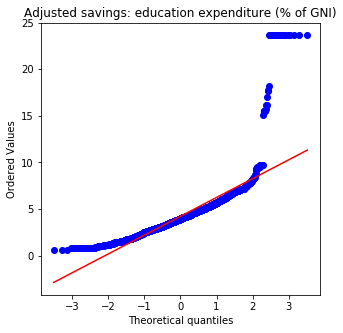

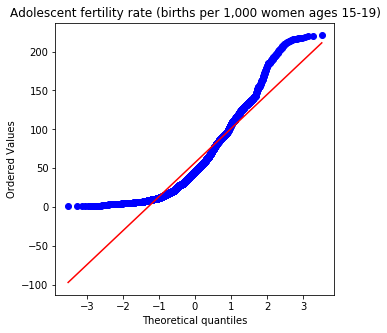

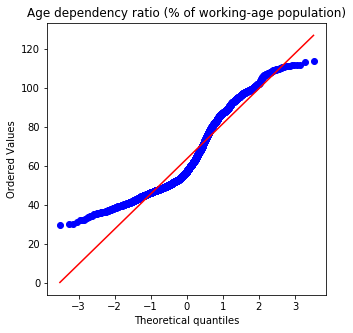

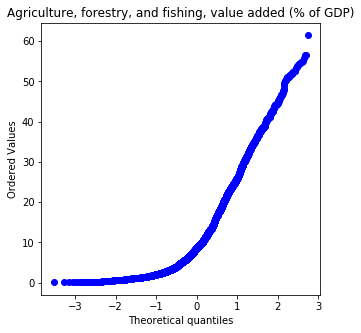

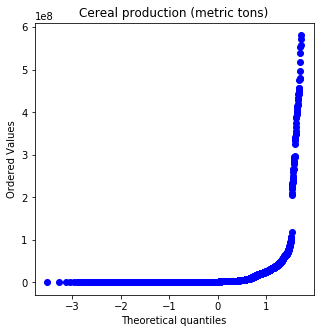

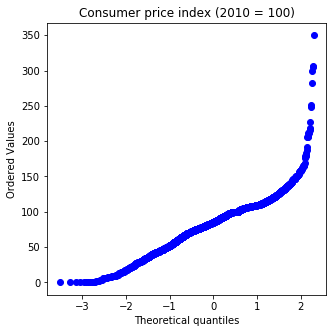

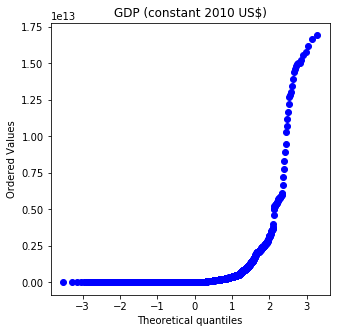

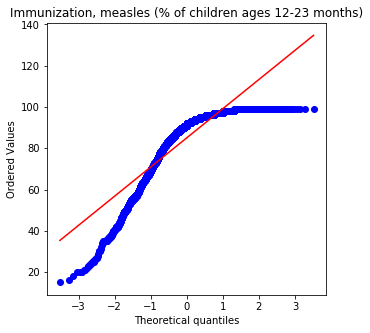

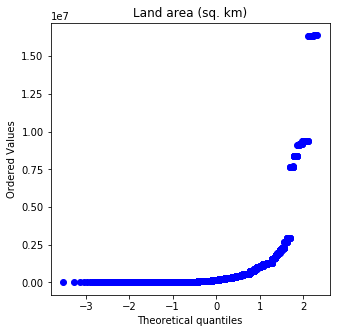

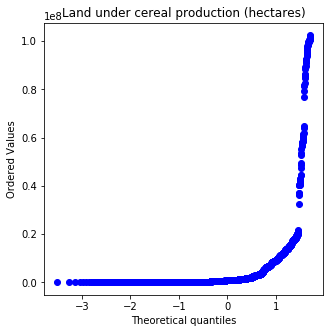

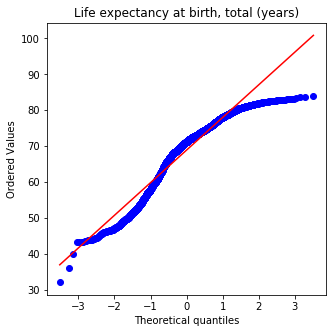

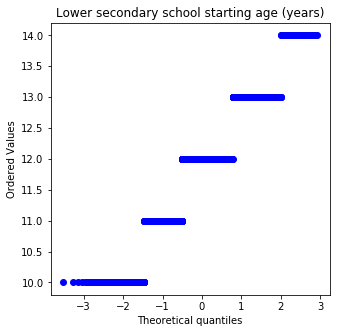

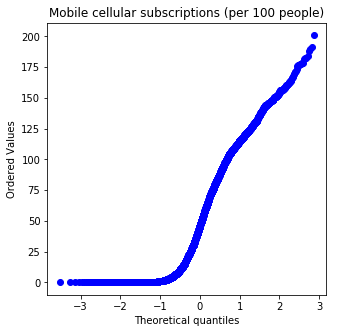

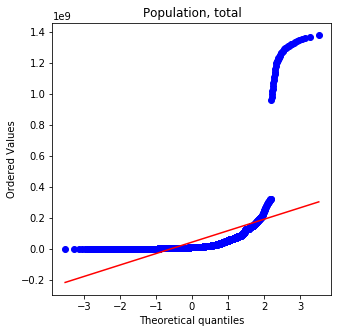

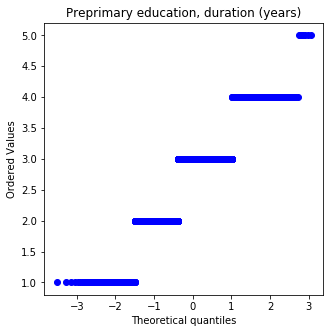

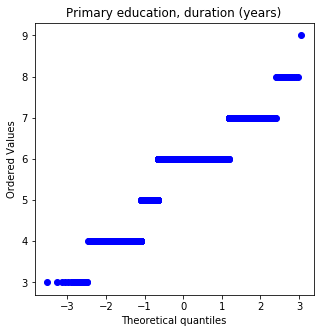

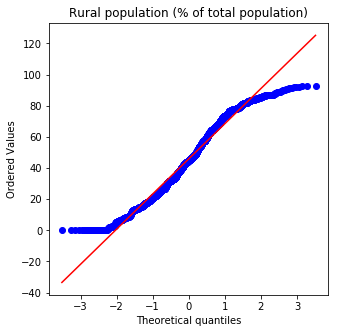

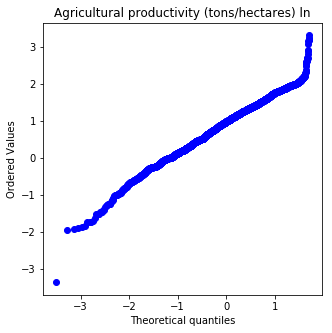

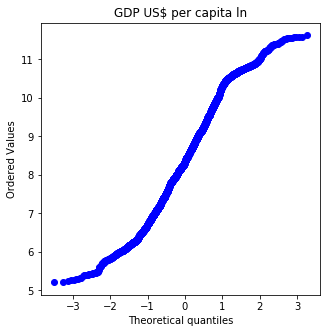

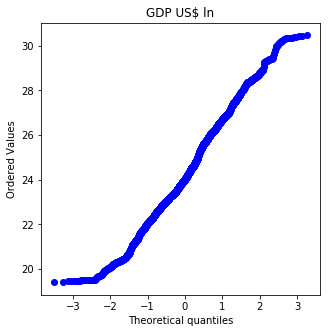

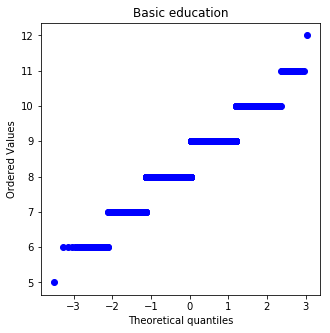

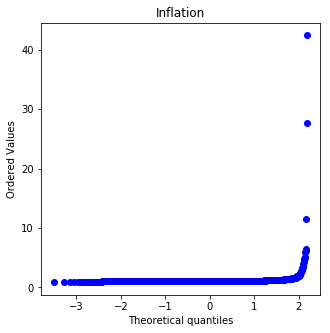

In [231]:
for x in list(df.columns.values):
    fig = plt.pyplot.figure(figsize=[5, 5])
    ax = fig.add_subplot(111)
    scipy.stats.probplot(df[x], dist="norm", plot=ax)
    ax.set_title(x)
    plt.pyplot.show()

We can see that indicators dont follow ~N distribution, although LN features got pretty close. GDP/population, and both agricultural derivative features were tested w/o logarithm and the results were farther from the normal dist.
For maximum likelihood estimation the data will need to be transformed to ~N dist.

Throwing away another bunch of indicators: education duration and their derivative, due to low correlation and ladder-like distribution; all basic indicators which were used to build derivative ones.

In [232]:
df=df.T
ids = ['Basic education', 'Birth rate, crude (per 1,000 people)', 'Cereal production (metric tons)', 'Consumer price index (2010 = 100)',
       'GDP (constant 2010 US$)', 'Land area (sq. km)', 'Land under cereal production (hectares)', 'Lower secondary school starting age (years)',
      'Population, total', 'Preprimary education, duration (years)', 'Primary education, duration (years)']
df=df[~df.index.isin(ids)]
df.shape

(12, 3168)

In [233]:
df_t=(df.isna().sum(axis=1, level="Country Name")/(df.isna().sum(axis=1, level="Country Name")+df.notna().sum(axis=1, level="Country Name")))
ldrop=[]
for i in df_t.columns.values:
    ldrop+=df_t.loc[df_t[i]>0.1].index.tolist()
del df_t
gc.collect()
print(set(ldrop))
df=df.drop(columns=ldrop, level="Country Name")

{'Agricultural productivity (tons/hectares) ln', 'Mobile cellular subscriptions (per 100 people)', 'Inflation'}


Now that we've finished clearing data and the dataframe is way less heavy, it's easier to just switch to regular dataframe style.

In [234]:
df2=df.T.reset_index()
df2=df2.drop(columns="level_0")
df2=df2.dropna()
df2["Year"] = df2["Year"].astype(float)
#df3 = df2.pivot_table(index='Year', columns=['Country Name'], dropna = False)
df2.rename(columns={'Adjusted savings: education expenditure (% of GNI)': 'Education exp. %GNI',
                   'Adolescent fertility rate (births per 1,000 women ages 15-19)' : 'Adolescent fertility rate',
                   'Age dependency ratio (% of working-age population)' : 'Age dependency ratio',
                   'Agriculture, forestry, and fishing, value added (% of GDP)' : 'Agriculture v.add. %GDP',
                   'Immunization, measles (% of children ages 12-23 months)' : 'Immunization, measles',
                   'Life expectancy at birth, total (years)' : 'Life expectancy',
                   'Mobile cellular subscriptions (per 100 people)' : 'Mobile sub./population',
                   'Rural population (% of total population)' : 'Rural population %',
                   'Agricultural productivity (tons/hectares) ln': 'Cereal tn/ha ln',}, inplace=True)
df2.shape

(2978, 14)

In [235]:












#df2=pd.read_excel("../input/data2.xlsx")
















Agriculture, immunization, life exp., and mobile subs show some time trend, but variance at each time period is far larger than the time explained, mobile subs also shows signs of heteroskedasticity based of year. 

We can also visually identify presense of heteroskedasticity as a function of TL in birth rate, agriculture share of value added, immunization, mobile subs, and GDP per capita.

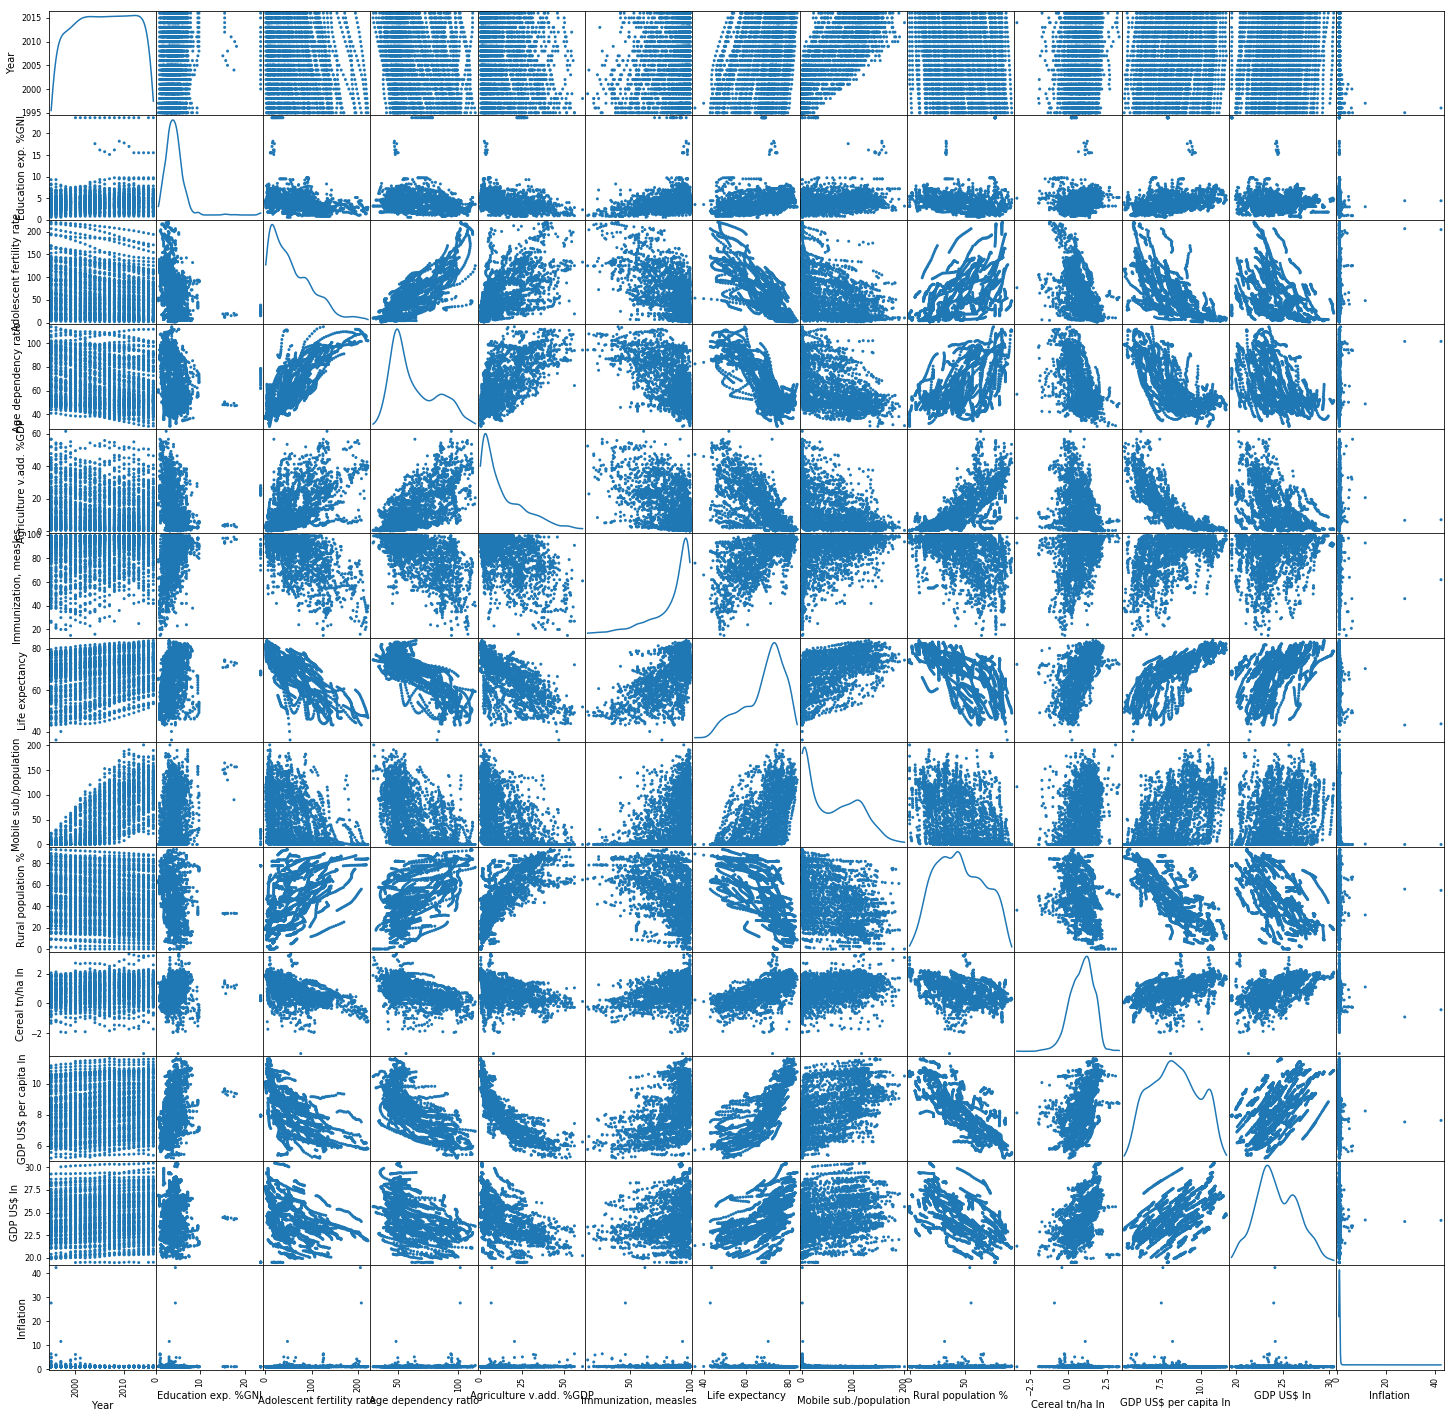

In [236]:
f,ax = plt.pyplot.subplots(figsize=(25, 25))
pd.plotting.scatter_matrix(df2, ax=ax, alpha=1, diagonal="kde")
plt.pyplot.show()

Average values across countries:

When values are averaged we can clearly see time dependancy across most features. Consequently, data becomes inter-correlated and develops autocorrelation (significant at up to 3-4 periods lag).

We wont be using averaged data for building models, since we might as well say that average life expectancy just depends on year.

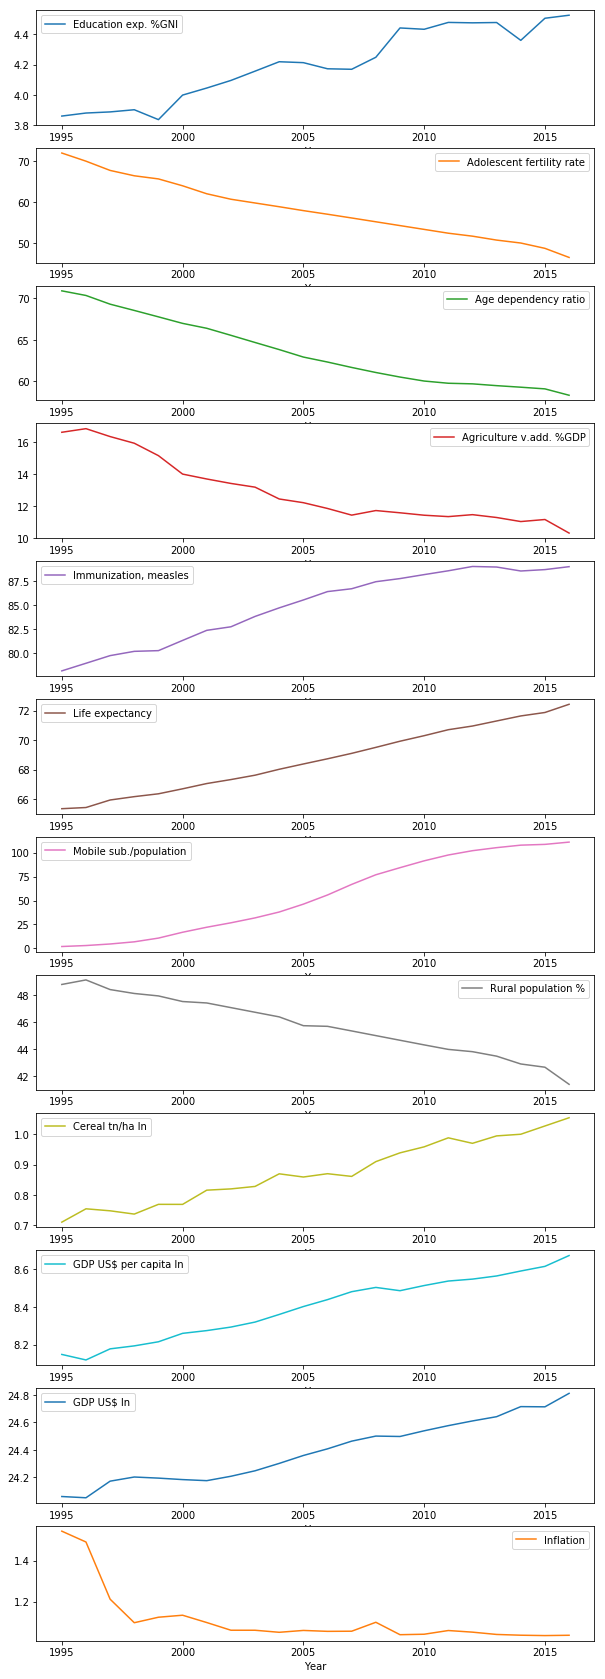

In [237]:
f,ax = plt.pyplot.subplots(figsize=(10, 30))
df2.groupby('Year').mean().plot(ax=ax, subplots=True)
plt.pyplot.show()

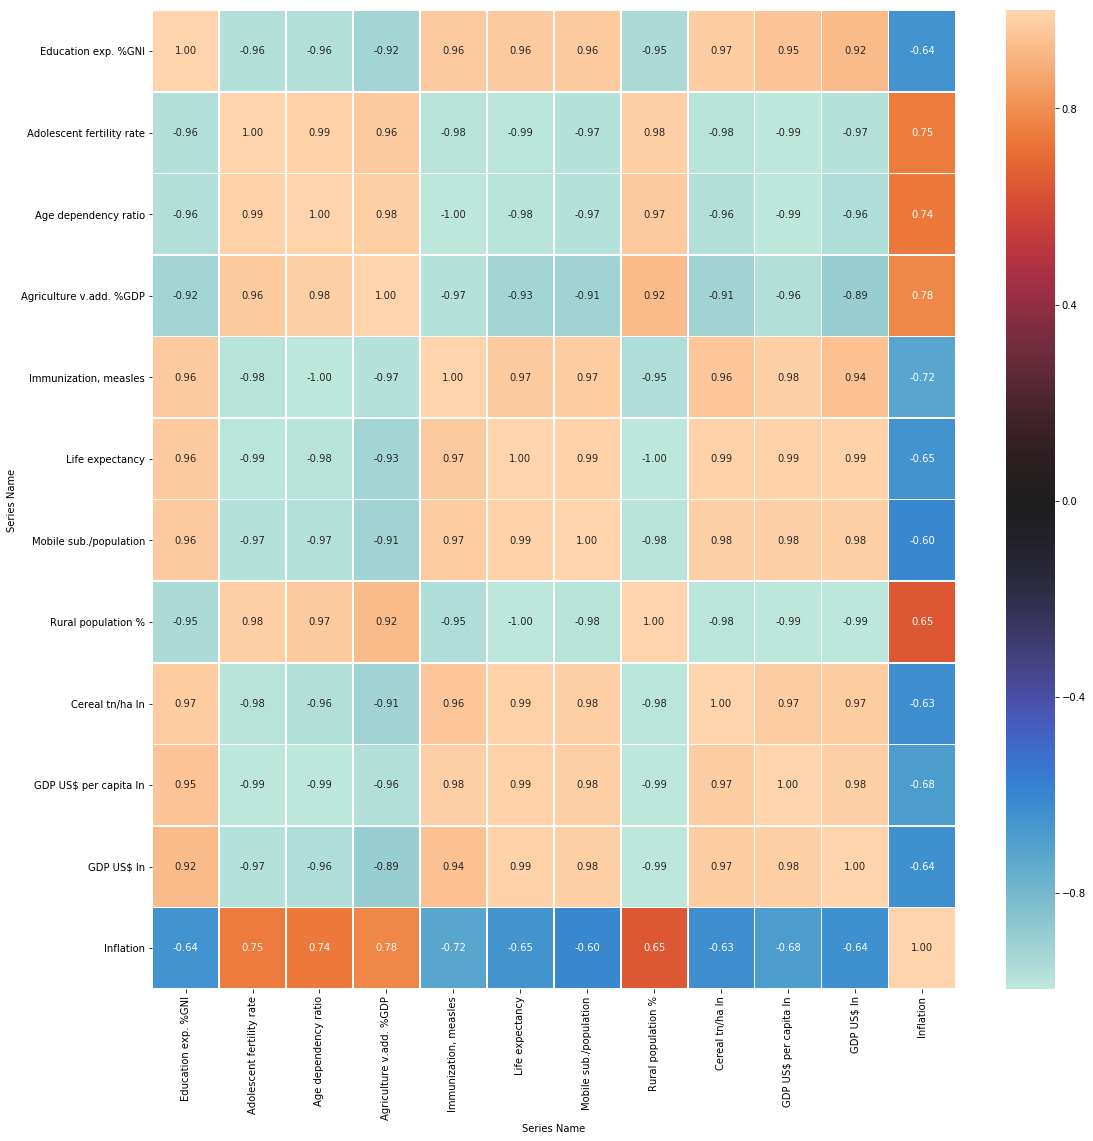

In [238]:
f,ax = plt.pyplot.subplots(figsize=(18, 18))
sns.heatmap(df2.groupby('Year').mean().corr(method='pearson'), annot=True, linewidths=.5, fmt= '.2f',ax=ax, center = 0)
plt.pyplot.show()

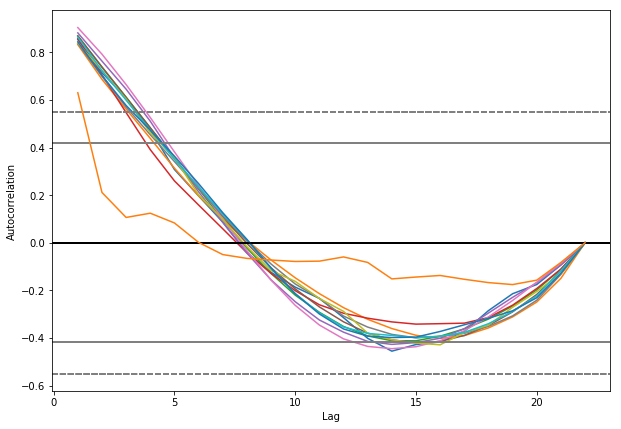

In [239]:
ldrop=list(df2.columns.values)
ldrop.remove('Country Name')
ldrop.remove('Year')
fig, ax = plt.pyplot.subplots(figsize=[10,7])
for x in ldrop:
    pd.plotting.autocorrelation_plot(df2.groupby('Year').mean()[x], ax=ax)

Distribution of TL across the countries. We can see that patterns vary, and countries with generally lower life expectancy have higher variance across years.

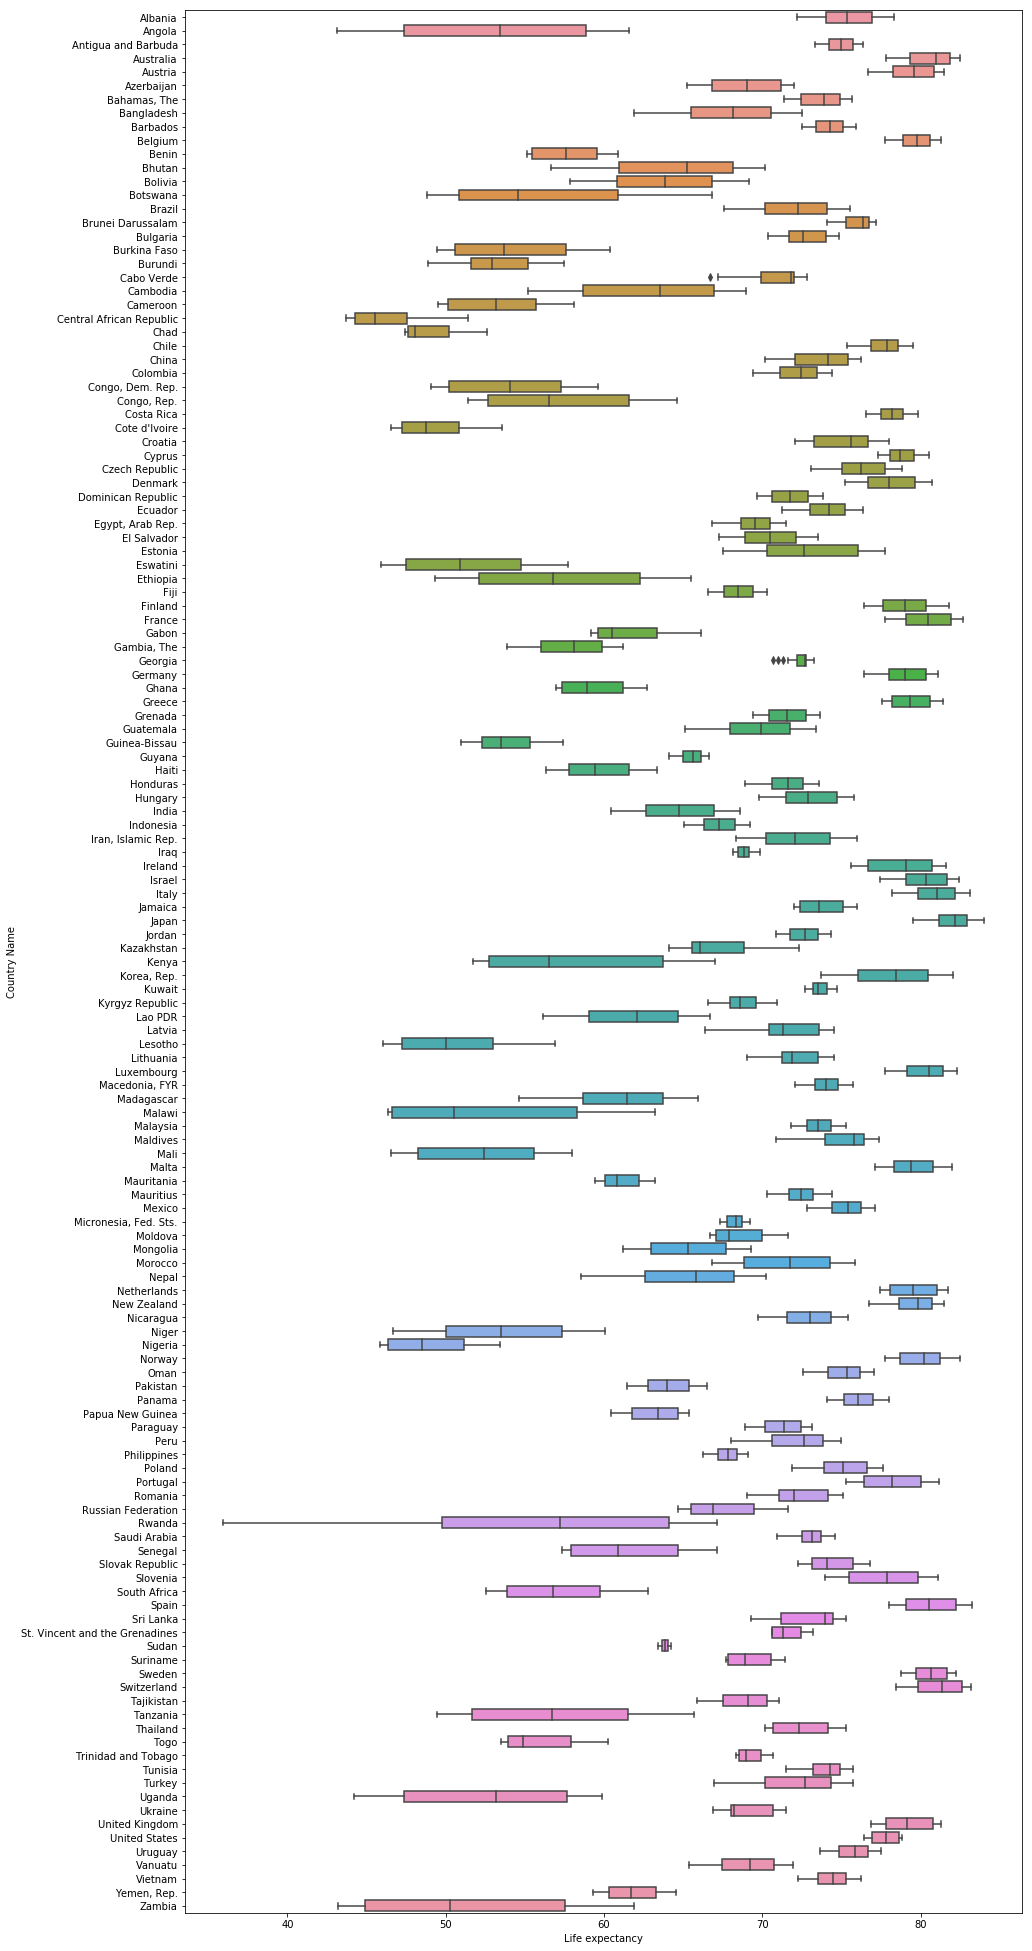

In [240]:
ldrop=list(df2.columns.values)
ldrop.remove('Country Name')
ldrop.remove('Life expectancy')
fig, ax = plt.pyplot.subplots(figsize=[15,35])
sns.boxplot(ax=ax, x='Life expectancy', y="Country Name", data=df2.drop(columns=ldrop), orient="h");

Let's look what we would get if we were to build a simple OLS of TL on GDP per capita:

There is definitely a pattern, but probably a non-linear one, even though GDP has already been subjected to log transformation. Residuals are not evenly distributed and show a pattern.

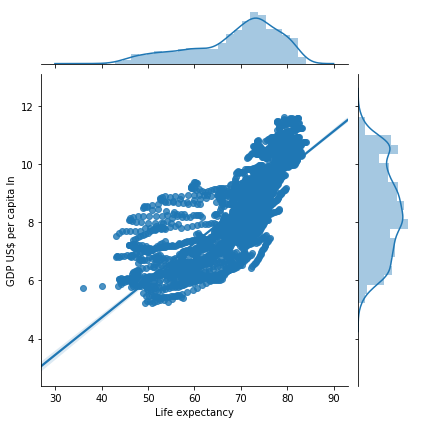

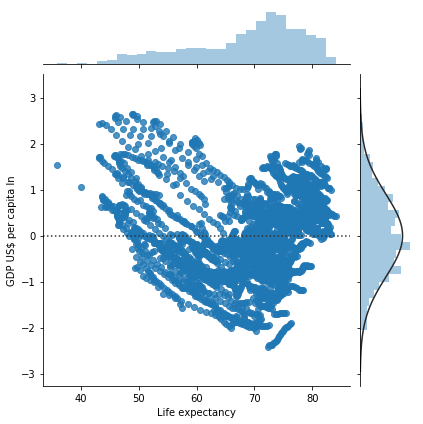

In [241]:
sns.jointplot(x='Life expectancy', y='GDP US$ per capita ln', data=df2, kind='reg');
sns.jointplot(x='Life expectancy', y='GDP US$ per capita ln', data=df2, kind='resid');

Following is the series of graphs showing distribution of TL in relation to immunization %.

The relation is not linear, and it looks like immunization has a positive effect on TL at lower levels of both life expectancy and immunization. Countries that have higher level of either feature (~70% immunization or ~65 years LE) display seemingly lower correlation, with few exceptions.

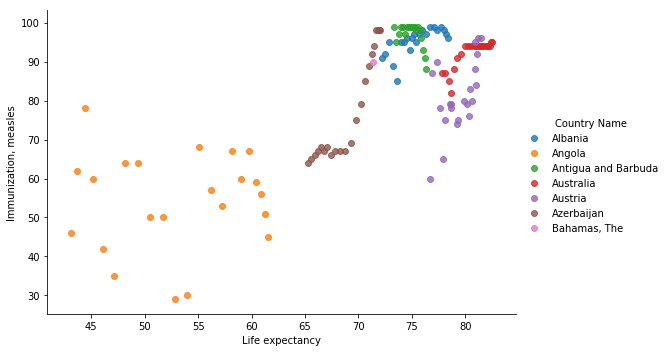

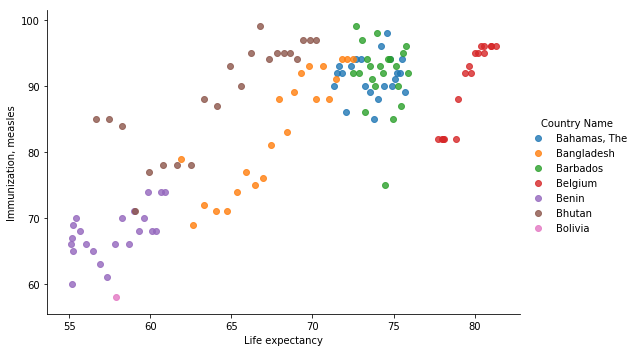

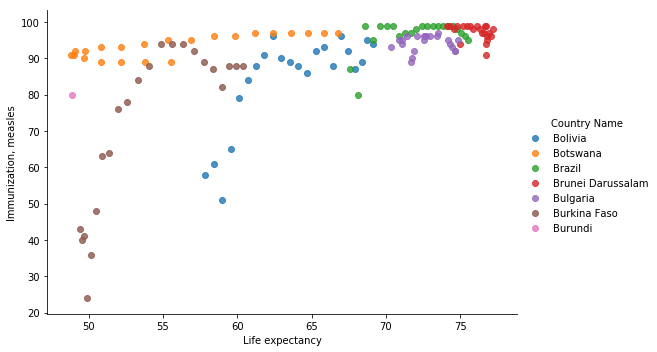

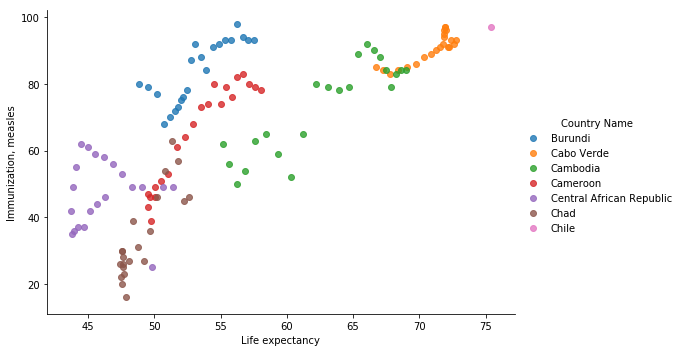

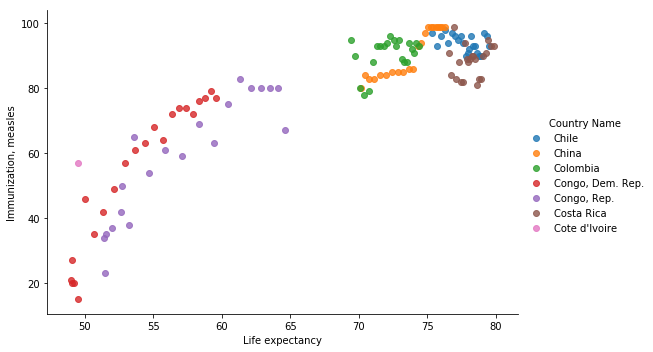

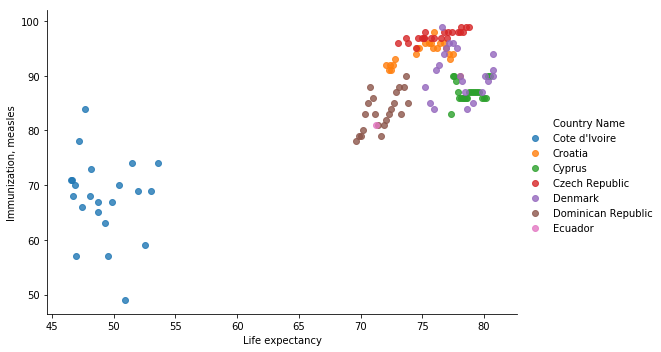

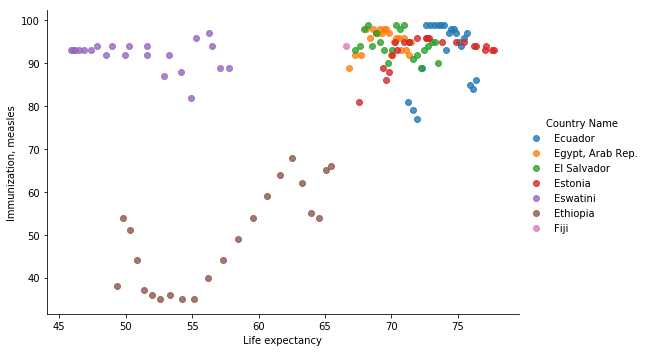

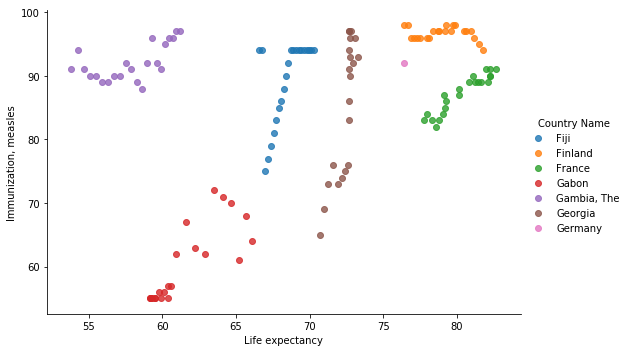

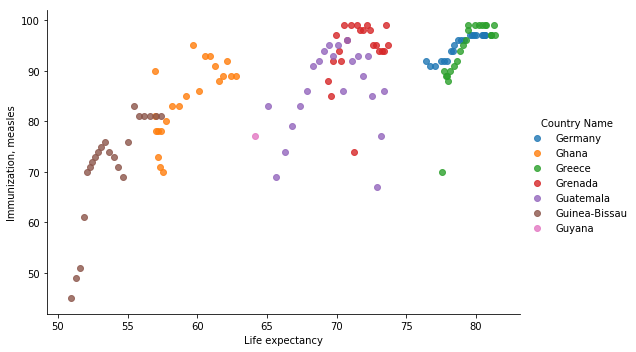

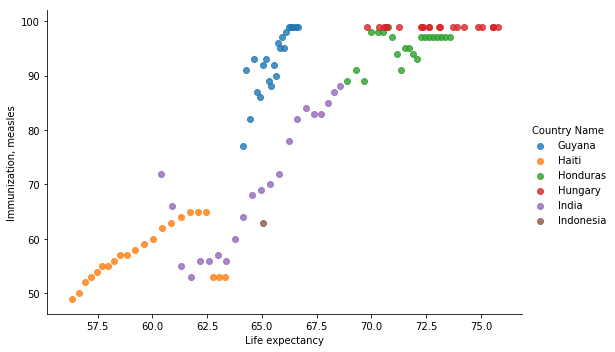

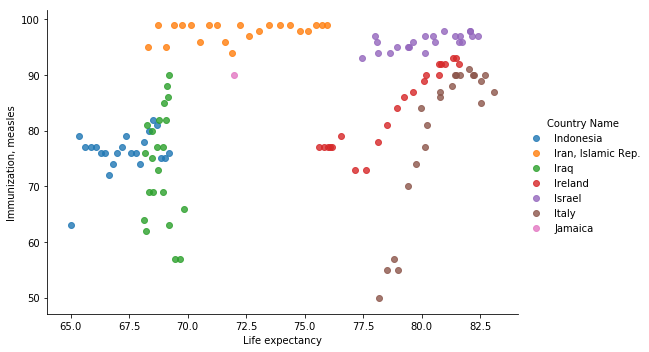

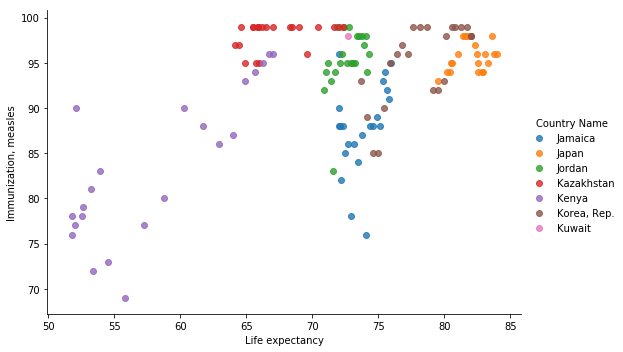

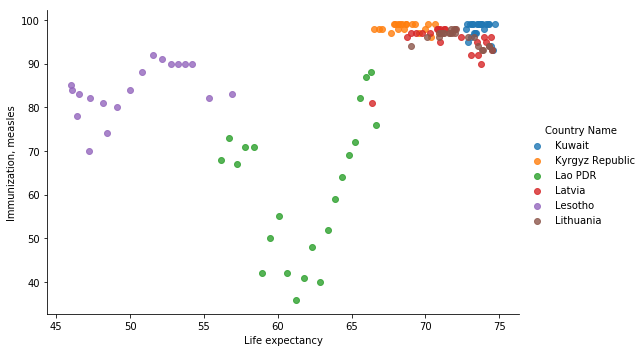

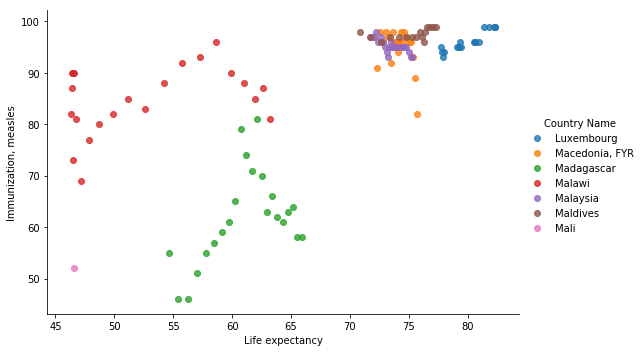

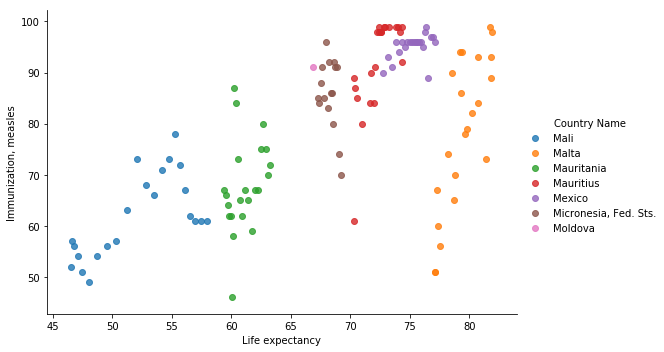

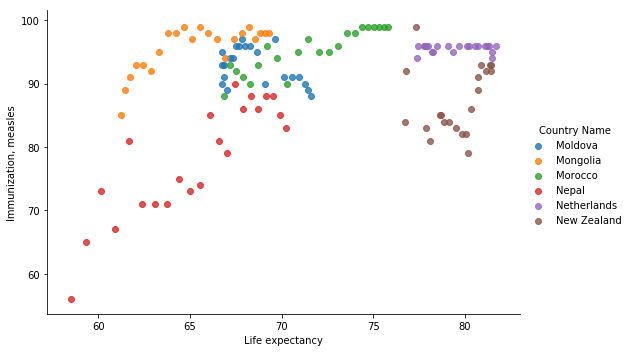

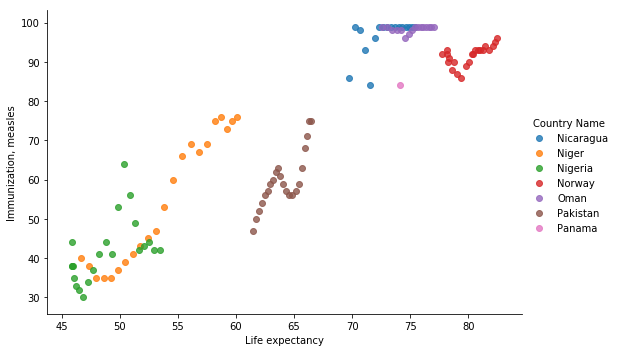

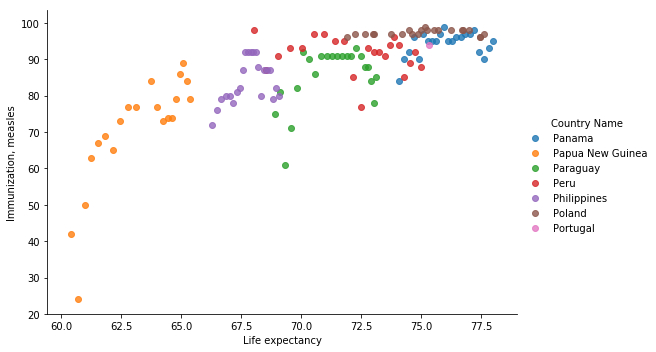

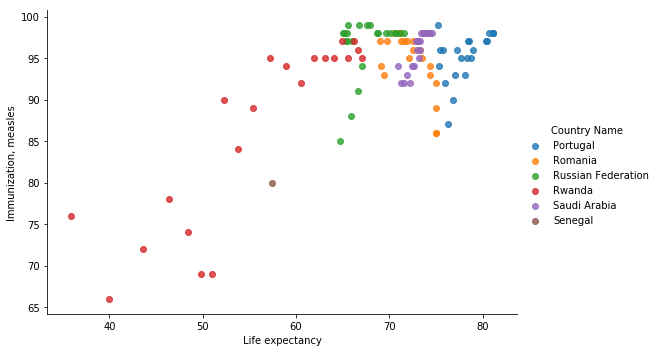

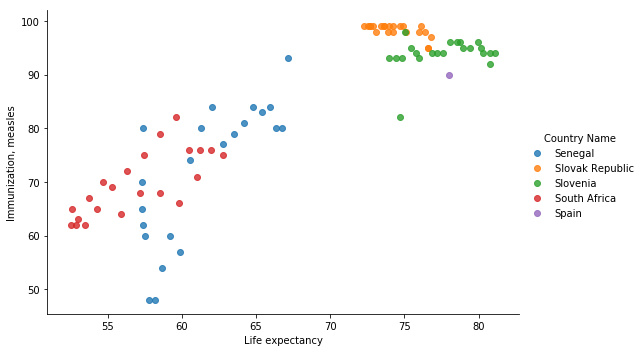

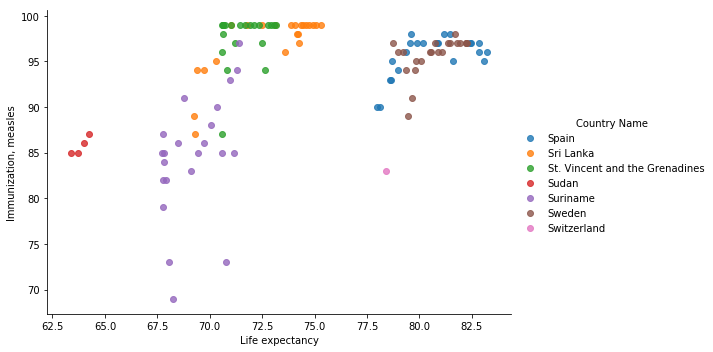

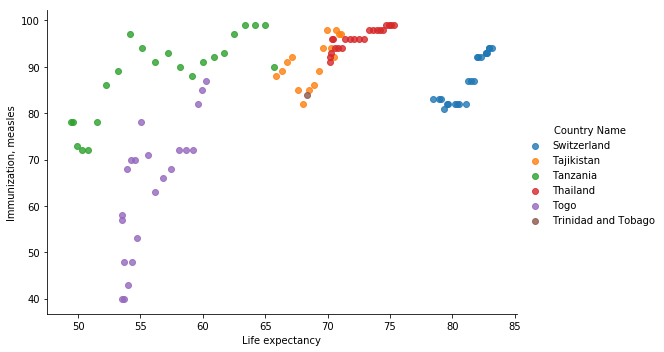

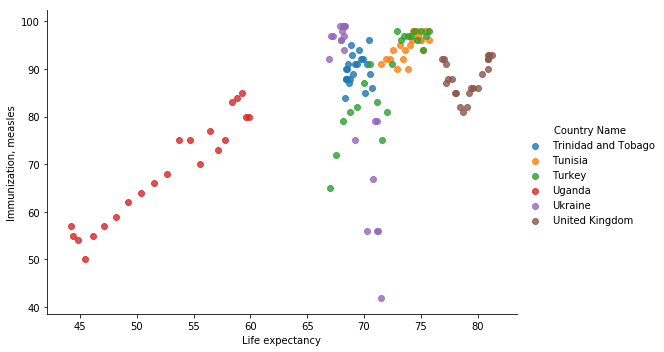

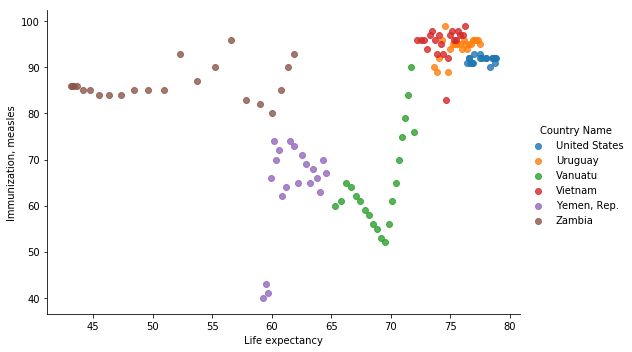

In [242]:
for x in range(1,25):
    sns.lmplot('Life expectancy', 'Immunization, measles', data=df2.loc[((x-1)*132):(x*132)], hue='Country Name', fit_reg=False, size=5, aspect=1.5);

But this theory is not confirmed to the data. The restricted model doesnt seem a lot better than full one.

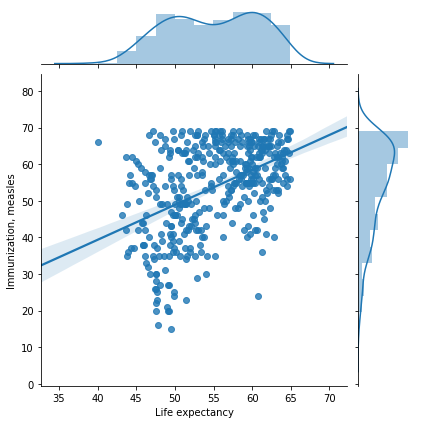

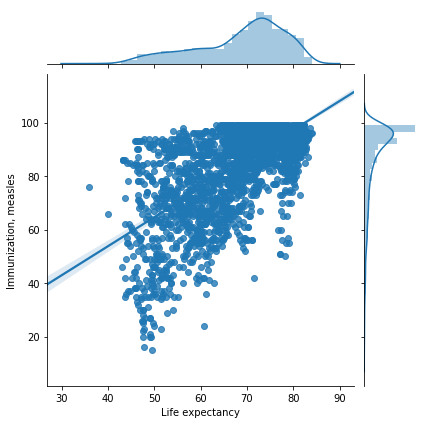

In [243]:
sns.jointplot(x='Life expectancy', y='Immunization, measles', data=df2[(df2['Immunization, measles'] < 70) & (df2['Life expectancy'] < 65)], kind='reg');
sns.jointplot(x='Life expectancy', y='Immunization, measles', data=df2, kind='reg');

Now back to the boring stuff. We need to do actual testing of multicollinearity, heteroskedasticity and autocorrelation.

MC: Variance inflation factor is caluclated for all explaining variables (TL removed, year also removed as it's an index that is just here in case we will need it, constant added, because otherwise it gives wrong result):

Two features have high VIF: Age dependency ratio and GDP US$ per capita ln. The first one can be dropped, since it doesnt have a strong theoretical reason to have high explanatory power. The second one should be left, unless it really causes trouble for the model. Removing GDP not per capita doesnt reduce VIF a lot.

In [244]:
df2 = add_constant(df2)
df_vif = df2
df_vif=df_vif.drop(columns='Country Name')
df_vif=df_vif.drop(columns='Year')
df_vif=df_vif.drop(columns='Life expectancy')

In [245]:
pd.Series([sm_ol.variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])], index=df_vif.columns)

const                       684.925
Education exp. %GNI           1.258
Adolescent fertility rate     3.910
Age dependency ratio          4.927
Agriculture v.add. %GDP       4.236
Immunization, measles         1.965
Mobile sub./population        1.498
Rural population %            3.093
Cereal tn/ha ln               1.988
GDP US$ per capita ln         6.277
GDP US$ ln                    1.889
Inflation                     1.022
dtype: float64

AC: Now we test a 2-factor regression for autocorrelation. Since all variables on average have it, we expect to confirm its presence on any variables.

In [246]:
sm_lm.OLS(df2['Life expectancy'], df2[['const','Immunization, measles', 'GDP US$ per capita ln']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     3983.
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:20:33   Log-Likelihood:                -8981.0
No. Observations:                2978   AIC:                         1.797e+04
Df Residuals:                    2975   BIC:                         1.799e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    18.1807      0.580     31.351      0.000      17.044      19.318
Immunization, measles     0.2017      0.007     30.324      0.000       0.189       0.215
GDP US$ per capita ln     3.9765      0.069     57.372      0.000       3.841       4.112
==============================================================================
Omnibus:                      628.897   Durbin-Watson:                   0.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1583.704
Skew:                          -1.144   Prob(JB):                         0.00
Kurtosis:                       5.744   Cond. No.                         557.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
df2['errors']=18.1527+(df2['Immunization, measles']*0.1982)+(df2['GDP US$ per capita ln']*4.0182)-df2['Life expectancy']

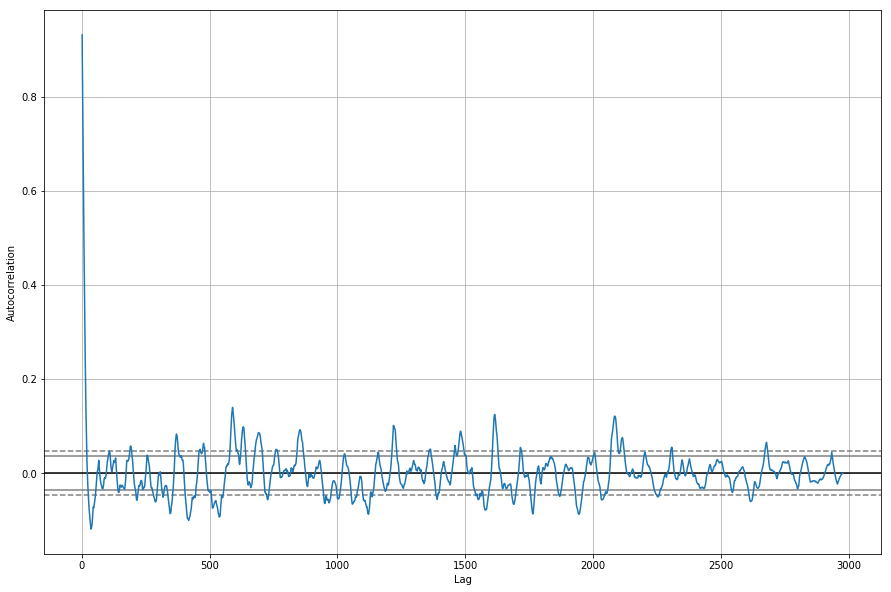

In [248]:
fig, ax = plt.pyplot.subplots(figsize=[15,10])
pd.plotting.autocorrelation_plot(df2['errors'], ax=ax)

Regression w/o intercept shows better R2, but autocorrelation has pretty much the same function.

As a result we can confirm that data is autocorrelated, so OLS estimations will have their significance inflated.

HS: we will use B-P test for heteroskedasticity for each variable based on OLS (TL, variable)

In [249]:
ldrop=list(df2.columns.values)
ldrop.remove('Country Name')
ldrop.remove('Life expectancy')
ldrop.remove('errors')
ldrop.remove('const')
for variable in ldrop:
    reg=sm_lm.OLS(df2['Life expectancy'], df2[['const', variable]]).fit()
    bp=sm_diag.het_breuschpagan(reg.resid, reg.model.exog)
    print(variable)
    print("LM_stat= " + str(bp[0]) + " lm_pvalue= " + str(bp[1]) + " fvalue= " + str(bp[2]) + " f_pvalue= " + str(bp[3]))
    print(" ")

Year
LM_stat= 56.06183055387524 lm_pvalue= 7.0227351547122e-14 fvalue= 57.09908904744512 f_pvalue= 5.4822413623708906e-14
 
Education exp. %GNI
LM_stat= 23.684383730474035 lm_pvalue= 1.1349979513819066e-06 fvalue= 23.858224758969094 f_pvalue= 1.0917743646452397e-06
 
Adolescent fertility rate
LM_stat= 92.74525305677197 lm_pvalue= 5.947791351426014e-22 fvalue= 95.66221956288987 f_pvalue= 2.9381370967990866e-22
 
Age dependency ratio
LM_stat= 44.2353260426098 lm_pvalue= 2.9117892248147634e-11 fvalue= 44.87215060955467 f_pvalue= 2.5052143899644122e-11
 
Agriculture v.add. %GDP
LM_stat= 0.6518383702221213 lm_pvalue= 0.41945618009262653 fvalue= 0.6515432137837867 f_pvalue= 0.41962598569970777
 
Immunization, measles
LM_stat= 13.94335544084795 lm_pvalue= 0.0001884024060112924 fvalue= 13.999538729508691 f_pvalue= 0.00018630826121812782
 
Mobile sub./population
LM_stat= 221.63596913543367 lm_pvalue= 3.9768835826488653e-50 fvalue= 239.29663744021605 f_pvalue= 5.601604861115868e-52
 
Rural popul

No surprise, HS was confirmed for agriculture share of value added, but the other indicators for some reason yielded negative result (fertility rate, immunization, mobile subs, and GDP per capita).